In [64]:
# stdlib
import math, sys, importlib
    
# packages
import numpy as np
from numpy import sqrt, pi
import matplotlib.pyplot as plt
from scipy import interpolate as interp
from scipy.integrate import quad, odeint

# local modules
import constants as c
import g_star

# set wide screen
from IPython.core.display import display, HTML, Latex
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
def test_interpolator(interpolator):
    g_rho_interp = interpolator(g_star.T, g_star.g_rho)
    g_s_interp = interpolator(g_star.T, g_star.g_s)
    plt.figure(figsize=(10, 5))
    N = 400
    T = np.logspace(np.log10(np.min(g_star.T)), np.log10(np.max(g_star.T)), N)
    
    plt.semilogx(T, g_rho_interp(T), "-b", label=r"$g_\rho$ Interpolated")
    plt.semilogx(T, g_s_interp(T), "--r", label=r"$g_\rho$ Interpolated")
    
    plt.semilogx(g_star.T, g_star.g_rho, "*b", label=r"$g_\rho$ Data")
    plt.semilogx(g_star.T, g_star.g_s, "+r", label=r"$g_s$ Data")

    plt.legend()
    plt.grid()
    plt.xlabel("T / eV")
    plt.ylabel("g")
    
    return g_rho_interp, g_s_interp

(<scipy.interpolate._cubic.CubicSpline at 0x7f534da99eb8>,
 <scipy.interpolate._cubic.CubicSpline at 0x7f534da99ba0>)

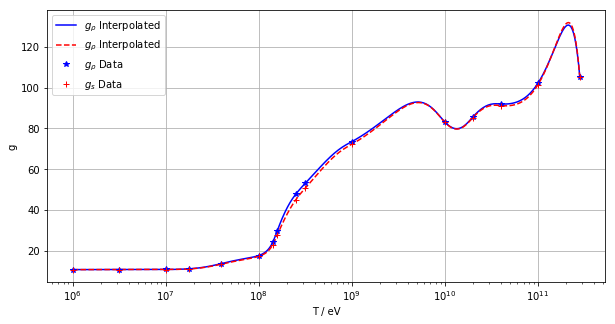

In [4]:
test_interpolator(interp.CubicSpline) # too many bumps

(<scipy.interpolate.interpolate.interp1d at 0x7f534ba2a818>,
 <scipy.interpolate.interpolate.interp1d at 0x7f534b7d0f98>)

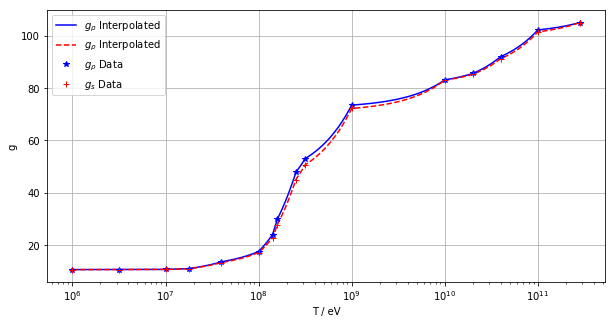

In [5]:
test_interpolator(interp.interp1d) # no derivative

(<scipy.interpolate._cubic.Akima1DInterpolator at 0x7f534b9f2f10>,
 <scipy.interpolate._cubic.Akima1DInterpolator at 0x7f534b9f2d58>)

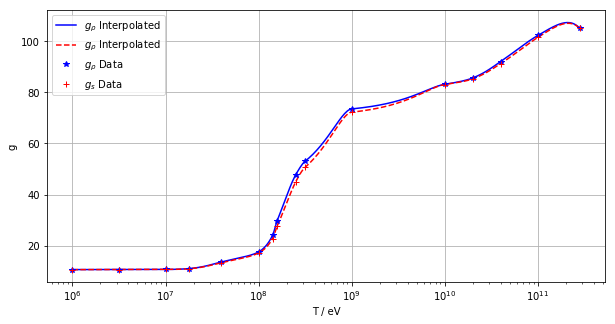

In [6]:
test_interpolator(interp.Akima1DInterpolator) # ok, little bump at the end

/usr/lib64/python3.7/site-packages/scipy/interpolate/polyint.py:609: RuntimeWarning: divide by zero encountered in true_divide
  p = np.dot(c,self.yi)/np.sum(c,axis=-1)[...,np.newaxis]


(<scipy.interpolate.polyint.BarycentricInterpolator at 0x7f534b9bda48>,
 <scipy.interpolate.polyint.BarycentricInterpolator at 0x7f534b9bd0e8>)

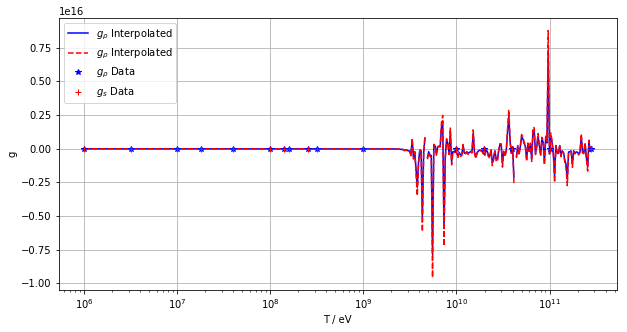

In [7]:
test_interpolator(interp.BarycentricInterpolator) # oh

(<scipy.interpolate.polyint.KroghInterpolator at 0x7f534b8b6548>,
 <scipy.interpolate.polyint.KroghInterpolator at 0x7f534b6eddb8>)

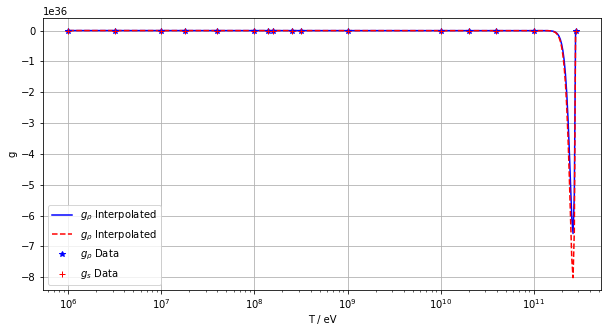

In [8]:
test_interpolator(interp.KroghInterpolator) # ooooh

(<scipy.interpolate._cubic.PchipInterpolator at 0x7f534b7de200>,
 <scipy.interpolate._cubic.PchipInterpolator at 0x7f534b7de0a0>)

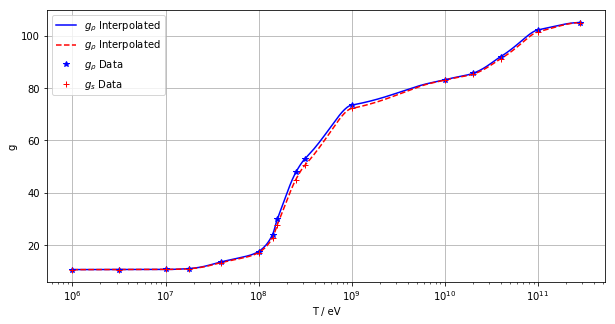

In [9]:
# ok, this one also uses cubic splines but only monotonic ones, therefore there are no bunmps
test_interpolator(interp.PchipInterpolator) 

In [10]:
# float(g_rho_interp.derivative()(1e9)) # how to get the derivative



$$
 \frac{\mathrm{d} t}{\mathrm{d} T}  = - M_\mathrm{pl} \sqrt{\frac{45}{64 \pi^3}} \frac{1}{T^3 g_s(T) \sqrt{g_\rho(T)}} (T g_\rho'(T) + 4 g_\rho(T))
$$

$$
\Rightarrow t(T) = t_0 + \int^T_{T(t = t_0)} \frac{\mathrm{d} t}{\mathrm{d} T} \mathrm{d} T
$$

$$
\frac{\mathrm{d} t}{\mathrm{d} T} \sim \frac{ 14 \cdot 10^{9} \mathrm{yr} }{ 10^{12} \mathrm{K} }
$$

In [114]:
def dtdT(T):
    return (
        # this is in 1/eV / eV = eV^-2
        - c.M_pl * sqrt(45 / (64 * pi**3)) * 
        1 / (T**3 * g_star.g_s_interp(T) * sqrt(g_star.g_rho_interp(T))) *
        (T*g_star.g_rho_interp_diff(T) + 4*g_star.g_rho_interp(T))
    )

ans = t, t_err = quad(dtdT, 100e6, 100e3) 

np.array(ans) / c.sc.elementary_charge * c.sc.hbar

array([1.48027470e+01, 1.89142116e-07])

Text(0.5,1,'Temperature of the Universe in the Radiation dominated epoch')

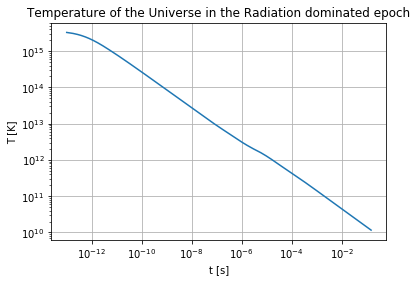

In [143]:
T = np.logspace(np.log10(np.min(g_star.T)), np.log10(np.max(g_star.T)), 400)[::-1]

t0 = 1e-13 * c.sc.elementary_charge / c.sc.hbar

t = odeint(lambda t, T: dtdT(T), t0, T)

#plt.loglog(T, t)
#plt.xlabel("T [eV]")
#plt.ylabel("t [1/eV]")

T_in_K = T * c.sc.elementary_charge / c.sc.Boltzmann 
t_in_s = t / c.sc.elementary_charge * c.sc.hbar
plt.loglog(t_in_s, T_in_K)
plt.ylabel("T [K]")
plt.xlabel("t [s]")
plt.grid()
plt.title("Temperature of the Universe in the Radiation dominated epoch")

In [137]:
"%e" % T_in_K[-1]

'1.160452e+10'

In [140]:
"%e" % T[-1]

'1.000000e+06'